In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import copy
import numpy as np
import yfinance as yf
import os

In [2]:
test = pd.read_csv('test.csv')

In [3]:
def trading_strat(true_values, yhat_lower, yhat_upper, model, H, ex, verbose=False, plot_strat=False):
    # Parameters for fees and premiums
    fee_percent = 0.001  # 0.1% transaction fee
    short_premium_daily = 0.0005  # 0.05% daily borrowing cost for shorting

    # Trading strategy variables
    free = 0  # To track the index until which no further trades can be made
    money = 100.0  # Initial cash balance
    shares = 0.0  # Number of shares currently held
    shorted_shares = 0.0  # Number of shares currently shorted
    portfolio_values = []  # To track portfolio values over time

    # Assuming x_test contains the dates for the evaluation period, add last 21 dates of train to test
    dates = test['Date']

    # Fetch S&P 500 data using yfinance
    sp500_data = yf.download('^GSPC', start=dates.min(), end=dates.max())
    sp500_data = sp500_data.reindex(dates, method='nearest')  # Align to x_test dates

    # Get the adjusted close prices for the benchmark
    sp500_prices = sp500_data['Adj Close']

    # Benchmark: Initial investment in S&P 500
    sp500_money = 100.0  # Same initial investment
    sp500_shares = sp500_money / sp500_prices.iloc[0]  # Buy S&P 500 at the first price
    sp500_portfolio_values = sp500_shares * sp500_prices  # Track S&P 500 portfolio values

    if verbose:
        print("Length of yhat_lower:", len(yhat_lower), "Length of true_values:", len(true_values), "Length of dates:", len(dates))


    # Initialize variables to track buy/sell/short/cover actions
    buy_points = []
    sell_points = []
    short_points = []
    cover_points = []

    # Execute the trading strategy
    for i in range(len(dates)):
        # print(portfolio_value)  # Ensure we don't go out of bounds
        # print(f"shorted shares: {shorted_shares}")
        if free < i:
            # Case 1: Buy when yhat_lower is above the actual price
            if i < len(yhat_lower) and yhat_lower[i] > true_values[i]:
                free = i + 21  # Lock the trading window for 21 days
                shares = money / true_values[i]  # Calculate shares to buy
                
                # Deduct the transaction cost for buying
                transaction_fee = shares * true_values[i] * fee_percent
                money -= shares * true_values[i] + transaction_fee
                if verbose:
                    print(f"Buying at {true_values[i]} on {dates.iloc[i]}, since yhat_lower is {yhat_lower[i]}")

                buy_points.append((dates.iloc[i], portfolio_values[-1] if portfolio_values else money))
                
            # Case 2: Short when yhat_upper is below the actual price
            elif i < len(yhat_lower) and yhat_upper[i] < true_values[i]:
                free = i + 21  # Lock the trading window for 21 days
                shorted_shares = money / true_values[i]  # Calculate shares to short
                
                # Add proceeds from short sale, deducting the transaction cost
                short_revenue = shorted_shares * true_values[i]
                transaction_fee = short_revenue * fee_percent
                money += short_revenue - transaction_fee
                if verbose:
                    print(f"Shorting at {true_values[i]} on {dates.iloc[i]}, since yhat_upper is {yhat_upper[i]}")

                short_points.append((dates.iloc[i], portfolio_values[-1] if portfolio_values else money))

        # Dynamically update portfolio value
        if shares > 0:  # If holding stocks
            portfolio_value = money + shares * true_values[i]
        elif shorted_shares > 0:  # If holding a short position
            portfolio_value = money - shorted_shares * true_values[i]  # Liability from short
            portfolio_value -= shorted_shares * true_values[i] * short_premium_daily  # Daily short premium cost
        else:
            portfolio_value = money  # Cash only

        portfolio_values.append(portfolio_value)

        # Finalize the trade after 21 days
        if free == i:
            if shares > 0:  # Sell the held shares
                sell_revenue = shares * true_values[i]
                transaction_fee = sell_revenue * fee_percent
                money += sell_revenue - transaction_fee
                if verbose:
                    print(f"Selling at {true_values[i]} on {dates.iloc[i]}")
                shares = 0

                sell_points.append((dates.iloc[i], portfolio_values[-1] if portfolio_values else money))
            elif shorted_shares > 0:  # Buy back the shorted shares
                buy_back_cost = shorted_shares * true_values[i]
                transaction_fee = buy_back_cost * fee_percent
                premium_cost = shorted_shares * true_values[i] * short_premium_daily * 30
                money -= buy_back_cost + transaction_fee + premium_cost
                if verbose:
                    print(f"Buying back at {true_values[i]} on {dates.iloc[i]}")
                shorted_shares = 0

                cover_points.append((dates.iloc[i], portfolio_values[-1] if portfolio_values else money))

    # Final cash balance of the trading strategy
    final_strategy_balance = money
    if verbose:
        print("Final cash balance from strategy:", final_strategy_balance)

    # Final cash balance from holding S&P 500
    final_sp500_balance = sp500_shares * sp500_prices.iloc[-1]
    if verbose:
        print("Final cash balance from holding S&P 500:", final_sp500_balance)

    # Convert portfolio values to a pandas series for easier calculations
    portfolio_values = pd.Series(portfolio_values, index=dates[:len(portfolio_values)])
    sp500_portfolio_values = sp500_shares * sp500_prices  # Already a Series

    # Helper function to calculate risk measures
    def calculate_metrics(portfolio_values, risk_free_rate=0.01):
        # Daily returns
        daily_returns = portfolio_values.pct_change().dropna()

        # Sharpe Ratio
        excess_returns = daily_returns - (risk_free_rate / 252)
        sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()

        # Sortino Ratio
        downside_returns = daily_returns[daily_returns < 0]
        sortino_ratio = np.sqrt(252) * excess_returns.mean() / downside_returns.std()

        # Maximum Drawdown
        cumulative_returns = (1 + daily_returns).cumprod()
        max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()

        return sharpe_ratio, sortino_ratio, max_drawdown

    # Calculate metrics for both strategies
    strategy_sharpe, strategy_sortino, strategy_mdd = calculate_metrics(portfolio_values)
    sp500_sharpe, sp500_sortino, sp500_mdd = calculate_metrics(sp500_portfolio_values["^GSPC"])

    if verbose:
        # Print results
        print("\n--- Risk Measures ---")
        print("Strategy:")
        print(f"Sharpe Ratio: {strategy_sharpe:.2f}")
        print(f"Sortino Ratio: {strategy_sortino:.2f}")
        print(f"Maximum Drawdown: {strategy_mdd:.2%}")

        print("\nS&P 500:")
        print(f"Sharpe Ratio: {sp500_sharpe:.2f}")
        print(f"Sortino Ratio: {sp500_sortino:.2f}")
        print(f"Maximum Drawdown: {sp500_mdd:.2%}")

    if plot_strat:
        dates = pd.to_datetime(dates)
        plt.figure(figsize=(14, 8))
        # Plot true stock values
        plt.plot(dates, true_values, label='Stock Price', linewidth=2, color='black')
        # Extract buy/sell/short/cover dates
        buy_dates, _ = zip(*buy_points) if buy_points else ([], [])
        sell_dates, _ = zip(*sell_points) if sell_points else ([], [])
        short_dates, _ = zip(*short_points) if short_points else ([], [])
        cover_dates, _ = zip(*cover_points) if cover_points else ([], [])

        # Track labels to avoid duplicates in the legend
        plotted_labels = set()
        # Plot buy/sell and short/cover points
        for date in buy_dates:
            date = pd.to_datetime(date)
            label = 'Buy' if 'Buy' not in plotted_labels else None
            if label:
                plotted_labels.add('Buy')
            index = dates.get_loc(date) if date in dates else dates.tolist().index(date)  # Get index safely
            plt.scatter(date, true_values[index], color='blue', marker='^', label=label, s=100)

        for date in sell_dates:
            date = pd.to_datetime(date)
            label = 'Sell' if 'Sell' not in plotted_labels else None
            if label:
                plotted_labels.add('Sell')
            index = dates.get_loc(date) if date in dates else dates.tolist().index(date)  # Get index safely
            plt.scatter(date, true_values[index], color='green', marker='^', label=label, s=100)

        for date in short_dates:
            date = pd.to_datetime(date)
            label = 'Short' if 'Short' not in plotted_labels else None
            if label:
                plotted_labels.add('Short')
            index = dates.get_loc(date) if date in dates else dates.tolist().index(date)  # Get index safely
            plt.scatter(date, true_values[index], color='orange', marker='v', label=label, s=100)

        for date in cover_dates:
            date = pd.to_datetime(date)
            label = 'Cover' if 'Cover' not in plotted_labels else None
            if label:
                plotted_labels.add('Cover')
            index = dates.get_loc(date) if date in dates else dates.tolist().index(date)  # Get index safely
            plt.scatter(date, true_values[index], color='red', marker='v', label=label, s=100)

        # Improve plot aesthetics
        if not ex:
            plt.title(f'Trading Actions on Stock Price\nUsing {model} Prediction with H={H}\nTotal Profit: +{final_strategy_balance - 100:.1f}%', fontsize=16)
        else:
            plt.title(f'Trading Actions on Stock Price\nUsing {model} Prediction with H={H} (EXO)\nTotal Profit: +{final_strategy_balance - 100:.1f}%', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Stock Price', fontsize=14)
        plt.legend(loc='best', fontsize=12)
        plt.xticks(rotation=45)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.tight_layout()
        # Show the plot
        plt.show()
    
    return final_strategy_balance, strategy_sharpe, strategy_sortino

In [4]:
pred_path = "predictions/"

# SARIMA

In [5]:
sarima_pred = os.path.join(pred_path, "predictions_SARIMA/")
H = 21
model = "SARIMA"
for ex in [False, True]:
    if ex:
        pred = pd.read_csv(os.path.join(sarima_pred, f"SARIMA_{H}_ex.csv"))
    else:
        pred = pd.read_csv(os.path.join(sarima_pred, f"SARIMA_{H}.csv"))

    true_values = test['Close']
    yhat_lower = list(pred['Lower_CI'])[2*H:]
    yhat_upper = list(pred['Upper_CI'])[2*H:]
    final_strategy_balance, strategy_sharpe, strategy_sortino  = trading_strat(true_values, yhat_lower, yhat_upper, model, H, ex, verbose=False, plot_strat=False)
    print(f"Strategy: {model} H={H} EXO={ex}\nProfit: +{final_strategy_balance - 100:.2f}%\nSharpe Ratio: {strategy_sharpe:.2f}\nSortino Ratio: {strategy_sortino:.2f}\n")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Strategy: SARIMA H=21 EXO=False
Profit: +263.75%
Sharpe Ratio: 3.32
Sortino Ratio: 4.92

Strategy: SARIMA H=21 EXO=True
Profit: +210.56%
Sharpe Ratio: 3.12
Sortino Ratio: 5.55



# Prophet

In [6]:
prophet_pred = os.path.join(pred_path, "predictions_Prophet/")
H = 21
model = "Prophet"
for ex in [False, True]:
    if ex:
        pred = pd.read_csv(os.path.join(prophet_pred, f"prophet_predictions_h{H}_exo.csv"))
    else:
        pred = pd.read_csv(os.path.join(prophet_pred, f"prophet_predictions_h{H}.csv"))

    true_values = test['Close']
    yhat_lower = list(pred['Lower Bound'])[H:]
    yhat_upper = list(pred['Upper Bound'])[H:]
    final_strategy_balance, strategy_sharpe, strategy_sortino = trading_strat(true_values, yhat_lower, yhat_upper, model, H, ex, verbose=False, plot_strat=False)
    print(f"Strategy: {model} H={H} EXO={ex}\nProfit: +{final_strategy_balance - 100:.2f}%\nSharpe Ratio: {strategy_sharpe:.2f}\nSortino Ratio: {strategy_sortino:.2f}\n")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Strategy: Prophet H=21 EXO=False
Profit: +25.23%
Sharpe Ratio: 0.65
Sortino Ratio: 0.84

Strategy: Prophet H=21 EXO=True
Profit: +181.67%
Sharpe Ratio: 2.48
Sortino Ratio: 4.10



## Plot Best Strategy as a Sanity Check

[*********************100%***********************]  1 of 1 completed


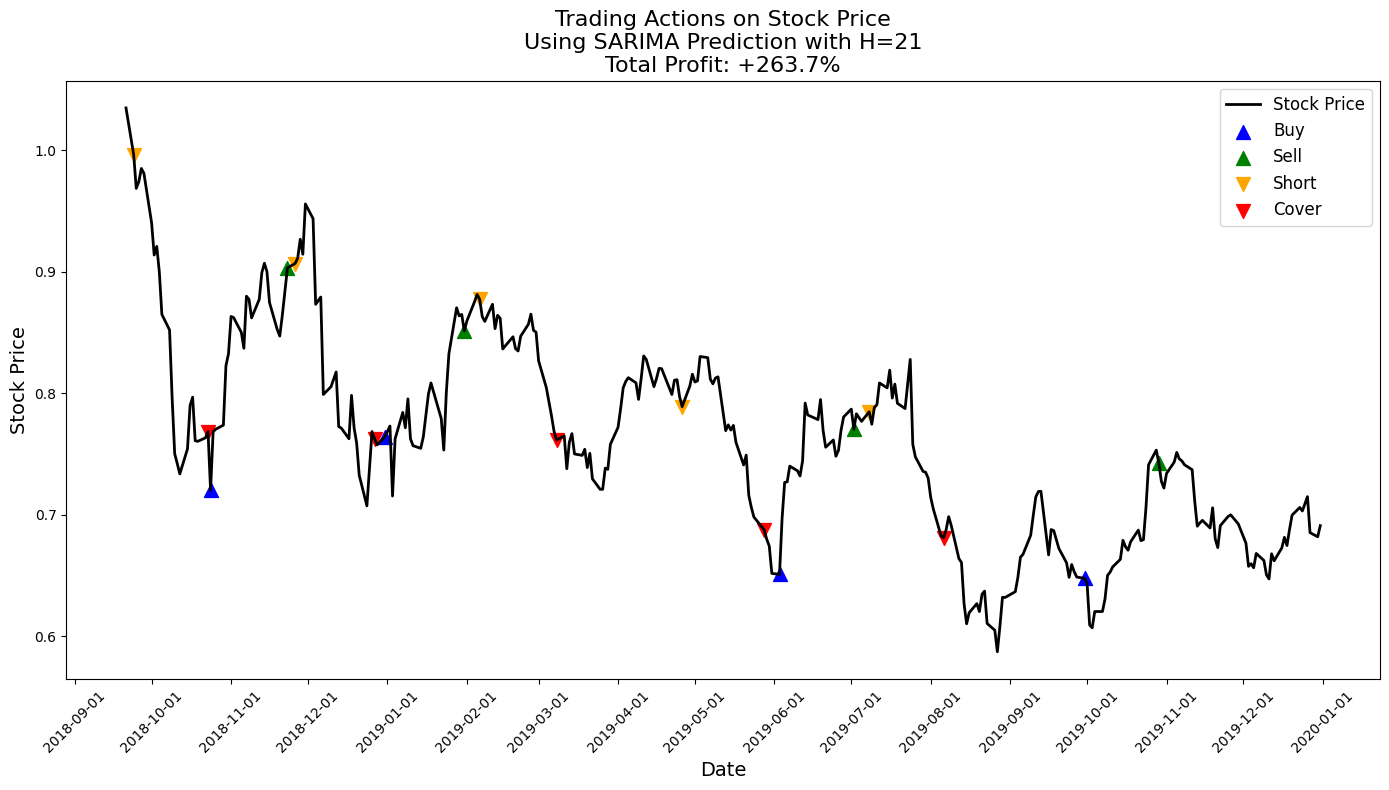

In [7]:
# plot best sarima strategy (H=21, EXO=False)
sarima_pred = os.path.join(pred_path, "predictions_SARIMA/")
H = 21
model = "SARIMA"
ex = False
pred = pd.read_csv(os.path.join(sarima_pred, f"SARIMA_{H}.csv"))

true_values = test['Close']

yhat_lower = list(pred['Lower_CI'])[2*H:]
yhat_upper = list(pred['Upper_CI'])[2*H:]

final_strategy_balance, strategy_sharpe, strategy_sortino = trading_strat(true_values, yhat_lower, yhat_upper, model, H, ex, verbose=False, plot_strat=True)